In [1]:
from PIL import ImageFont, ImageDraw, Image
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import label
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
import os
from tqdm import tqdm

In [3]:
data_path = '/data/steeve/mandarin/frames/'
frame_list = glob.glob(f'{data_path}/*')

In [4]:
import os

In [5]:
font_list =  os.listdir('/usr/share/fonts/truetype/')
font_list = [f for f in font_list if '.ttf' in f] 
font_list

['yahei.ttf', 'wt024.ttf', 'BKT.ttf', 'rouhei.ttf']

In [6]:
def get_multi_masks(img):
#     label = img.copy()
#     label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
#     print(img.shape)
#     thresh = threshold_otsu(img)
    _, thresh = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
#     bw = closing(img > thresh, square(3))

    # remove artifacts connected to image border
#     cleared = bw.copy()
#     clear_border(cleared)

    # label image regions
#     label_image = label(cleared)
#     bw = closing(image > thresh)
    return label(thresh)

In [7]:
def multi_mask_to_color_overlay(multi_mask, image=None, color=None):

    height,width = multi_mask.shape[:2]
    overlay = np.zeros((height,width,3),np.uint8) if image is None else image.copy()
    num_masks = int(multi_mask.max())
    if num_masks==0: return overlay

    if type(color) in [str] or color is None:
        #https://matplotlib.org/xkcd/examples/color/colormaps_reference.html

        if color is None: color='summer'  #'cool' #'brg'
        color = plt.get_cmap(color)(np.arange(0,1,1/num_masks))
        color = np.array(color[:,:3])*255
        color = np.fliplr(color)
        #np.random.shuffle(color)

    elif type(color) in [list,tuple]:
        color = [ color for i in range(num_masks) ]

    for i in range(num_masks):
        mask = multi_mask==i+1
        overlay[mask]=color[i]
        #overlay = instance[:,:,np.newaxis]*np.array( color[i] ) +  (1-instance[:,:,np.newaxis])*overlay

    return overlay

In [8]:
def generate(file_name, text, font_type, text_location = 0.84 , draw_number=1, font_size = 22):
    im = cv2.imread(file_name)
    y, x,_ = im.shape
    im = im[:int((0.6)*y),:,:]
    firstcrop_y, firstcrop_x,_ = im.shape
    cv2_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # cv2和PIL中颜色的hex码的储存顺序不同

    pil_im = Image.fromarray(np.zeros([firstcrop_y, firstcrop_x,3]).astype('uint8'))
    draw = ImageDraw.Draw(pil_im) # 括号中为需要打印的canvas，这里就是在图片上直接打印

    font = ImageFont.truetype(font_type, font_size, encoding="utf-8")
    
    x, y = pil_im.width, pil_im.height
    x /=2
    y = text_location * y
    shadowcolor = (0, 0, 0)

    text_width, text_height = font.getsize(text)
    x = x-text_width /2
    for i in range(draw_number):
        draw.text((x-1, y), text, font=font, fill=shadowcolor)
        draw.text((x+1, y), text, font=font, fill=shadowcolor)
        draw.text((x, y-1), text, font=font, fill=shadowcolor)
        draw.text((x, y+1), text, font=font, fill=shadowcolor)
    
    draw.text((x, y), text, (255, 255, 255), font=font)
    pil_im = cv2.cvtColor(np.array(pil_im), cv2.COLOR_BGR2GRAY)
    multi_masks = get_multi_masks(np.array(pil_im))
   
    
    sample = Image.fromarray(cv2_im)

    draw = ImageDraw.Draw(sample) 
    font = ImageFont.truetype(font_type, font_size, encoding="utf-8")
    x, y = sample.width, sample.height
    x /=2
    y = text_location * y
    x = x-text_width /2
    for i in range(draw_number):
        draw.text((x-1, y), text, font=font, fill=shadowcolor)
        draw.text((x+1, y), text, font=font, fill=shadowcolor)
        draw.text((x, y-1), text, font=font, fill=shadowcolor)
        draw.text((x, y+1), text, font=font, fill=shadowcolor)
    draw.text((x, y), text, (255, 255, 255), font=font)
    sample = np.array(sample)
    image_label_overlay = multi_mask_to_color_overlay(multi_masks, image=sample)
    
    return sample, multi_masks, image_label_overlay

In [9]:
def get_input_text():
    with open('input/meng_zi_processed.txt', 'rb') as f:
        texts = [t.decode('utf-8').strip() for t in f.readlines()]
    
    with open('input/lunyu_processed.txt', 'rb') as f:
        texts += [t.decode('utf-8').strip() for t in f.readlines()]
        
    with open('input/liangshiqiu_processed.txt', 'rb') as f:
        texts += [t.decode('utf-8').strip() for t in f.readlines()]
    return texts

In [10]:
all_texts = get_input_text()
len(all_texts)

6941

In [11]:
sampled_images = np.random.choice(glob.glob('/data/ITRI-create-speech-recognition-dataset/mandarin/frames/*'), size=len(all_texts))
sampled_fonts = np.random.choice(font_list, size=len(all_texts))
text_locations = np.random.uniform(low=0.7, high=0.84, size=len(all_texts))
font_sizes = np.random.choice(np.arange(23,26), size=len(all_texts))
draw_numbers = np.random.choice(np.arange(1, 10), size= len(all_texts))

In [12]:
def file_name_to_id(file_name):
    return file_name.split('/')[-1].split('.png')[0]

In [ ]:
for index, text in enumerate(tqdm(all_texts)):
    if index < 3000:continue
    fn = sampled_images[index]
    ft = sampled_fonts[index]
    tl = text_locations[index]
    fs = font_sizes[index]
    dn = draw_numbers[index]
    id_ = file_name_to_id(fn)
    image, multi_masks, overlay = generate(fn, text, ft, tl , dn, fs)
    plt.imshow(multi_masks)
    
#     break
    np.save(f'/data/mask_rcnn/multi_masks/{id_}.npy', multi_masks)
    cv2.imwrite(f'/data/mask_rcnn/multi_masks/{id_}.png', multi_masks)
    cv2.imwrite(f'/data/mask_rcnn/overlays/{id_}.png', overlay)
    cv2.imwrite(f'/data/mask_rcnn/images/{id_}.png', image)

100%|██████████| 6941/6941 [06:07<00:00, 18.88it/s]  


# Check if generated files are Okay

In [2]:
data_dir = '/data/mask_rcnn/'

In [3]:
ids = os.listdir(data_dir + 'images')
ids = [i.split('.png')[0] for i in ids ]
ids

['-VBZP1xe1_E-0001536-2.0',
 'L3EfENrenWo-0001583-2.0',
 '5jwrkK7W0uw-0001457-2.0',
 'LvaQeTOqgF0-0001953-2.0',
 'vhgnvzrcvAI-0002574-2.0',
 'yN6VLfznglE-0002162-2.0',
 'F51RTSqY-GU-0002568-2.0',
 'XFsf8ITLQeQ-0003750-2.0',
 'hIVIDURrik4-0000765-2.0',
 'oxM42KBy_Wg-0000137-2.0',
 'aS-3ayGo3J0-0002404-2.0',
 'a3vPqTLZ_oE-0001180-2.0',
 '-wYUcUc5VgQ-0000583-2.0',
 'XFp2uJiQpnA-0000796-2.0',
 'Dkmu3Qgzqrs-0000888-2.0',
 'BwHFmh77ojQ-0000638-2.0',
 'lGoYwOMT4O8-0003173-2.0',
 'ALRhUG3C4e4-0004358-2.0',
 'swKJqvSc3ek-0004301-2.0',
 'EP7bPvspb7A-0001552-2.0',
 'DTfHpK5W4M4-0001033-2.0',
 'pHvPuQai57Y-0000907-2.0',
 'jftczga56hI-0000448-2.0',
 'k7_ctM5fjrw-0000122-2.0',
 'hIVIDURrik4-0004388-2.0',
 'Io7fQ7glPhc-0000675-2.0',
 'Dj8o7JJSFf0-0000849-2.0',
 'vbTxrT7Akw4-0003994-2.0',
 '3Sy5RJUuxds-0000748-2.0',
 'lGoYwOMT4O8-0001292-2.0',
 '8a5xN5x5ZM8-0002567-2.0',
 '1J8Xjwfhd3o-0001897-2.0',
 'pMYyWMWluwg-0003692-2.0',
 'jChCvapS3YQ-0001963-2.0',
 'HCSl-BxHnkY-0002306-2.0',
 'ZtTBujc9XFY-000025

10
8
11
12


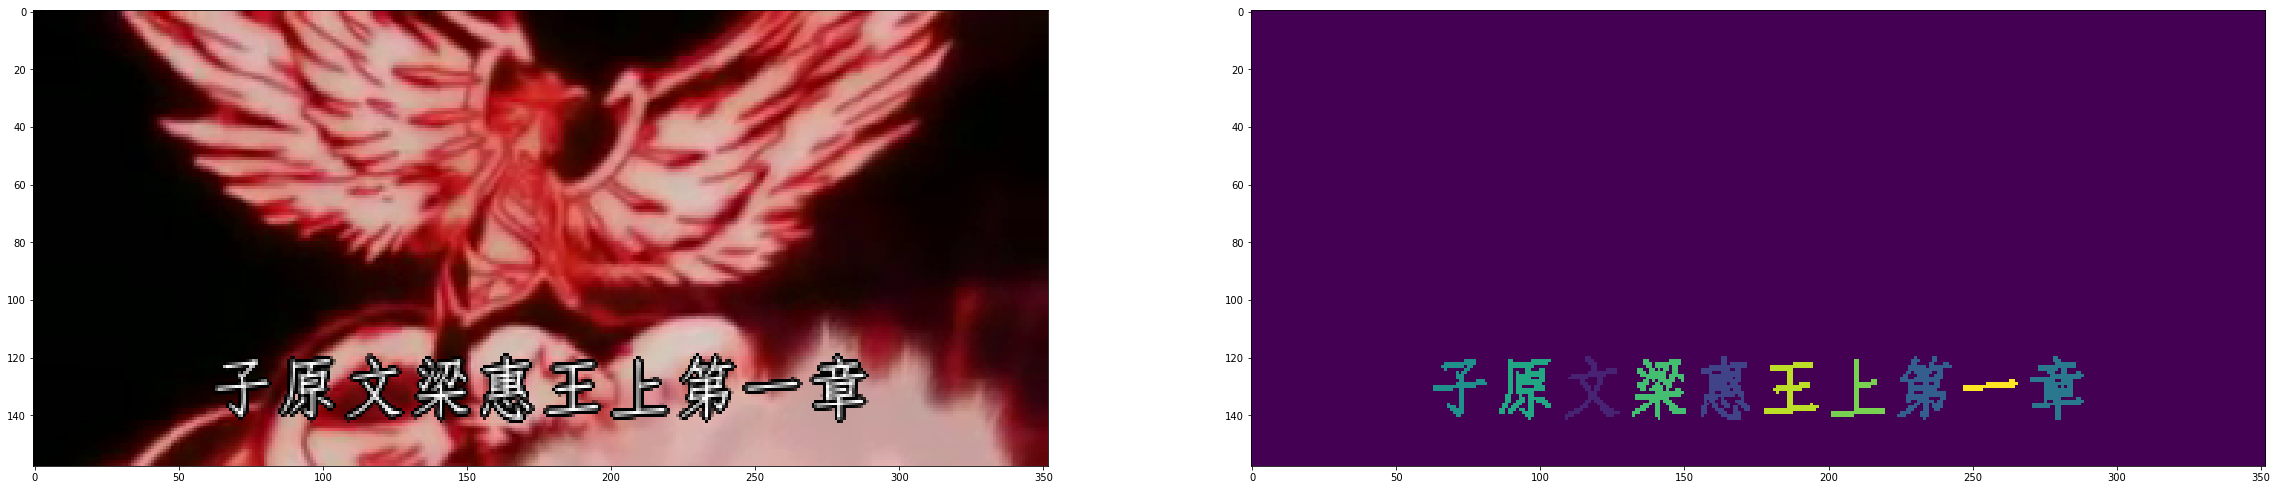

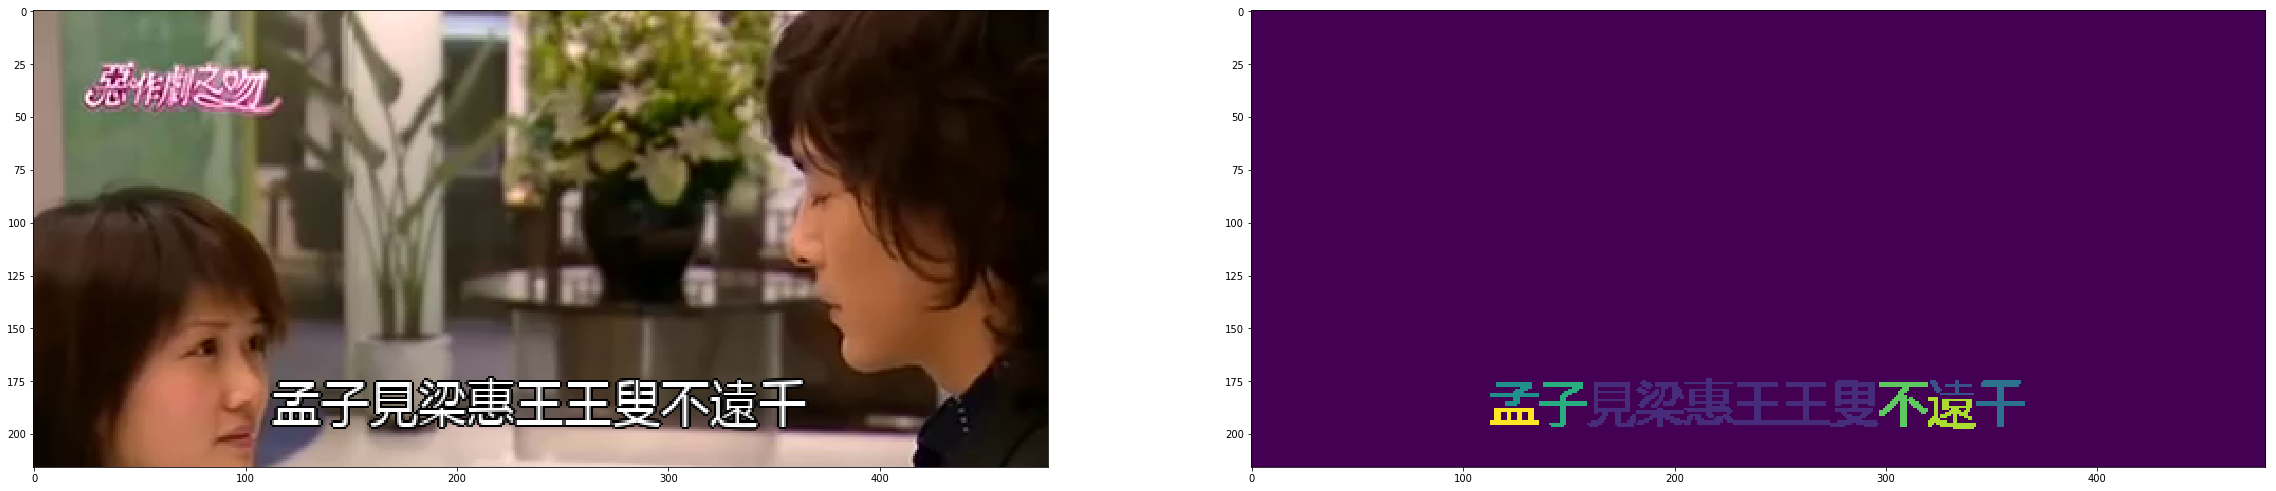

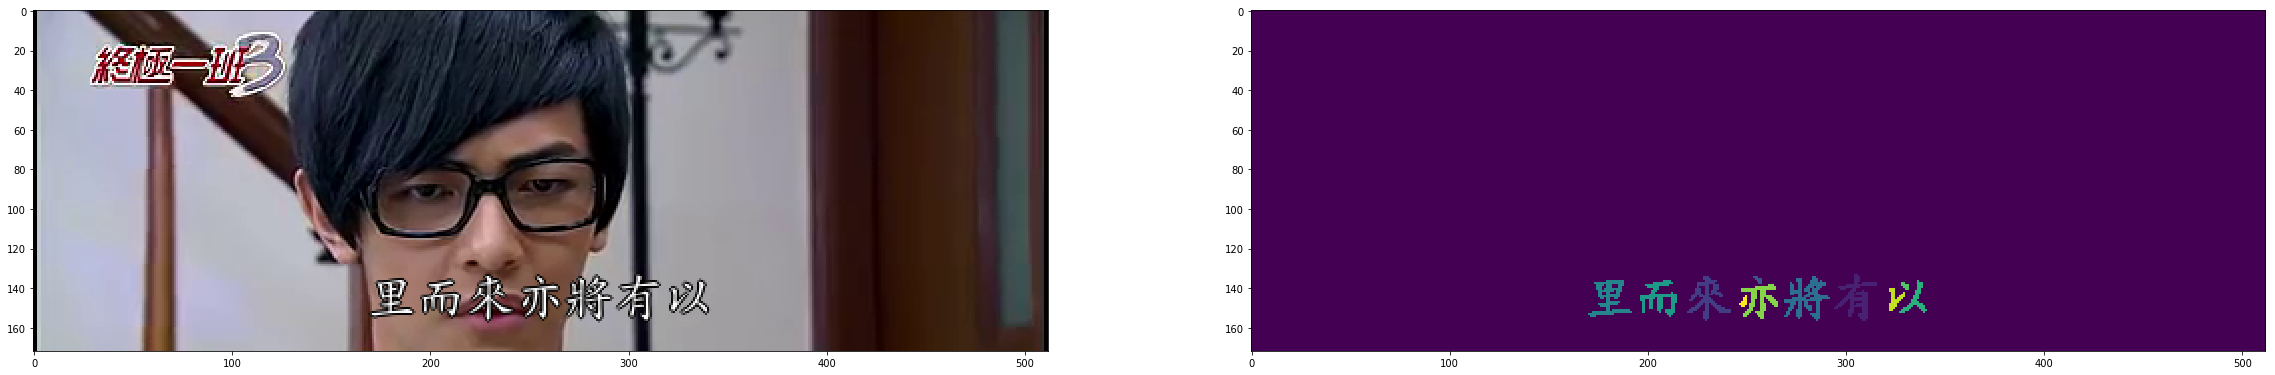

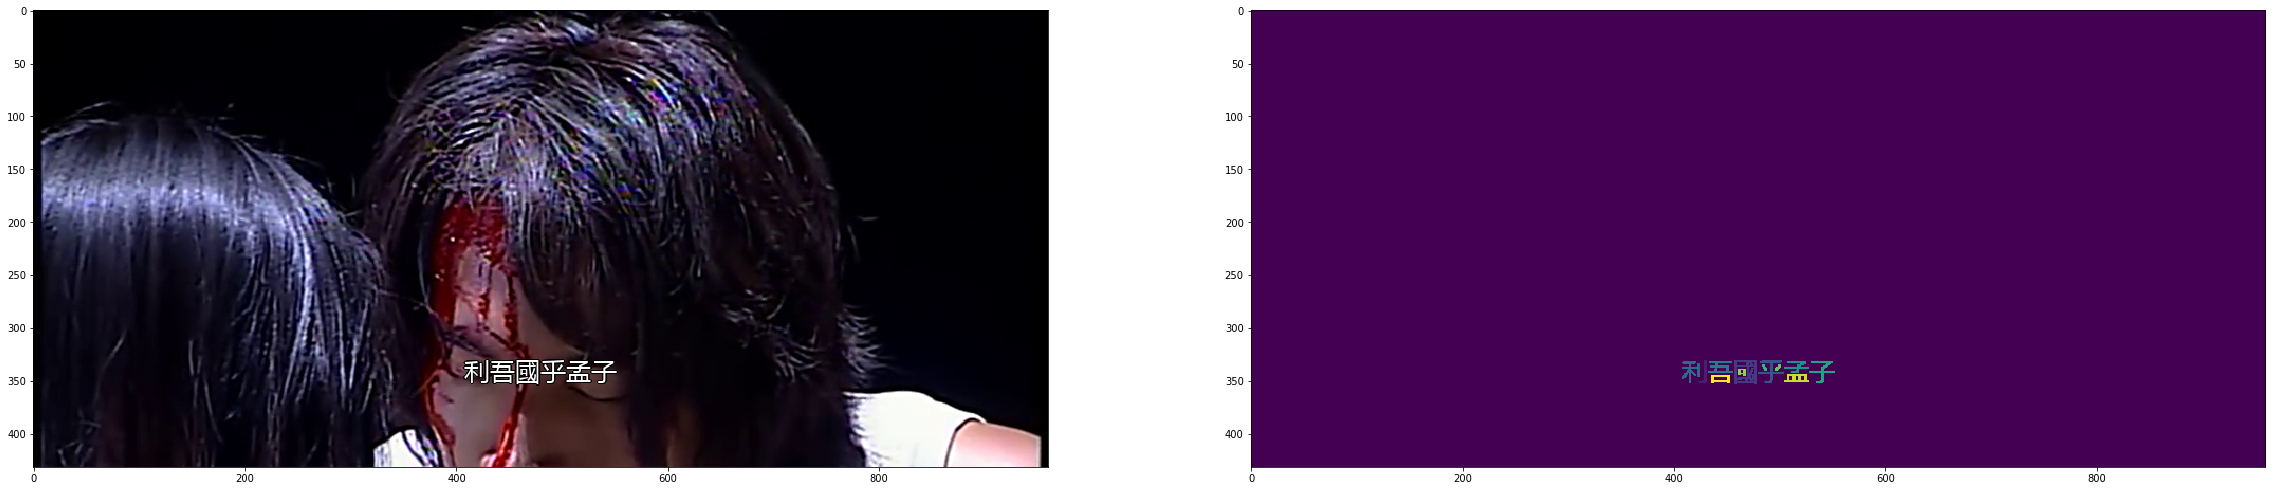

In [4]:
for id_ in ids[:4]:
    image = cv2.imread(data_dir+f'images/{id_}.png')
    overlay = cv2.imread(data_dir + f'overlays/{id_}.png')
    multi_masks = np.load(data_dir + f'multi_masks/{id_}.npy')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
#     print(data_dir+'images/{id_}.png')
    print(multi_masks.max())
    ax[0].imshow(image)
#     ax[1].imshow(overlay)
    ax[1].imshow(multi_masks)

In [7]:
all_ids = [ id.split('.png')[0] for id in os.listdir(data_dir+'/images')]
all_ids

['-VBZP1xe1_E-0001536-2.0',
 'L3EfENrenWo-0001583-2.0',
 '5jwrkK7W0uw-0001457-2.0',
 'LvaQeTOqgF0-0001953-2.0',
 'vhgnvzrcvAI-0002574-2.0',
 'yN6VLfznglE-0002162-2.0',
 'F51RTSqY-GU-0002568-2.0',
 'XFsf8ITLQeQ-0003750-2.0',
 'hIVIDURrik4-0000765-2.0',
 'oxM42KBy_Wg-0000137-2.0',
 'aS-3ayGo3J0-0002404-2.0',
 'a3vPqTLZ_oE-0001180-2.0',
 '-wYUcUc5VgQ-0000583-2.0',
 'XFp2uJiQpnA-0000796-2.0',
 'Dkmu3Qgzqrs-0000888-2.0',
 'BwHFmh77ojQ-0000638-2.0',
 'lGoYwOMT4O8-0003173-2.0',
 'ALRhUG3C4e4-0004358-2.0',
 'swKJqvSc3ek-0004301-2.0',
 'EP7bPvspb7A-0001552-2.0',
 'DTfHpK5W4M4-0001033-2.0',
 'pHvPuQai57Y-0000907-2.0',
 'jftczga56hI-0000448-2.0',
 'k7_ctM5fjrw-0000122-2.0',
 'hIVIDURrik4-0004388-2.0',
 'Io7fQ7glPhc-0000675-2.0',
 'Dj8o7JJSFf0-0000849-2.0',
 'vbTxrT7Akw4-0003994-2.0',
 '3Sy5RJUuxds-0000748-2.0',
 'lGoYwOMT4O8-0001292-2.0',
 '8a5xN5x5ZM8-0002567-2.0',
 '1J8Xjwfhd3o-0001897-2.0',
 'pMYyWMWluwg-0003692-2.0',
 'jChCvapS3YQ-0001963-2.0',
 'HCSl-BxHnkY-0002306-2.0',
 'ZtTBujc9XFY-000025

In [8]:
np.random.shuffle(all_ids)

In [9]:
valid_ids = all_ids[:400]
train_ids = all_ids[400:]
len(valid_ids), len(train_ids)

(400, 6898)

In [10]:
with open('/data/mask_rcnn/split/valid_ids', 'w') as f:
    for id in valid_ids:
        f.write(f'{id}\n')

In [11]:
with open('/data/mask_rcnn/split/train_ids', 'w') as f:
    for id in train_ids:
        f.write(f'{id}\n')